In [1]:
# Imports
import tensorflow as tf
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
#imports
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import matplotlib 
matplotlib.rcParams['text.usetex']=True
import matplotlib.pyplot as plt
from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.animation import FuncAnimation

#newer imports
from random import random, seed
from sklearn.linear_model import SGDRegressor
import seaborn as sns


def plot_imshow(data, extent_vec, colours, fsize, figure_name, colourbar_label): 
	fig = plt.figure()
	axes = plt.gca()
	mynorm = matplotlib.cm.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
	img = axes.imshow(data, extent=extent_vec, cmap=plt.get_cmap(colours), norm=mynorm)
	plt.xlabel(r'x, $1/L$', fontsize=fsize)
	plt.ylabel(r't, $L^2/\pi^2$', fontsize=fsize)
	plt.xticks(fontsize=fsize)
	plt.yticks(fontsize=fsize)
	cbar = fig.colorbar(img, ax=axes)
	cbar.set_label(colourbar_label, fontsize=fsize)
	cbar.ax.tick_params(labelsize=fsize)
	plt.savefig(figure_name, format="pdf")

In [203]:
class NNEigenSolver(tf.keras.Sequential): 
    def __init__(self, hidden_layers, A, learning_rate=0.001): 
        super(NNEigenSolver, self).__init__()# Initing sequential
        self.size_of_matrix = A.shape[0]
        self.A_train = tf.convert_to_tensor(A, dtype=tf.float32)
        self.A_predict = tf.convert_to_tensor(A, dtype=tf.float32)
        # Neural network initialization
        self.add(tf.keras.layers.Dense(hidden_layers[0], input_shape=(1, ), activation="linear"))
        for l in range(1, len(hidden_layers)): 
            self.add(tf.keras.layers.Dense(hidden_layers[l], activation="sigmoid"))
        self.add(tf.keras.layers.Dense(self.size_of_matrix, activation="linear"))
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) #ADAM optimizer
        self.cost_function = tf.keras.losses.MeanSquaredError() # MEAN SQUARED ERROR
        self.Id_mat = tf.eye(self.size_of_matrix, dtype=tf.float32) # Identity matrix 6x6
    # Trains the system
    def train(self, x, t, iterations): 
        self.start_x = x
        self.t_N = t
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        t = tf.convert_to_tensor(t, dtype=tf.float32)
        x, t = tf.meshgrid(x, t)
        x, t = tf.reshape(x, [-1, 1]), tf.reshape(t, [-1, 1])
        self.x, self.t = x, t
        eigvals = np.zeros(iterations)
        t_max = tf.reshape(self.t[-1], [-1,1])
        eigvecs = np.zeros((iterations, self.size_of_matrix))
        iter_array = np.zeros(iterations)
        cost_iter = np.zeros(iterations)
        for i in range(iterations): 
            cost, gradients = self.gradients()
            iter_array[i] = i
            cost_iter[i] = cost
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables)) 
            eigval, eigvec = self.eigenproblem(self.start_x, t_max)
            eigvecs[i,:] = eigvec[:]
            eigvals[i] = eigval
            if (i==int(iterations/5)): 
                print("A fifth of iterations done.")
            if (i==int(2*iterations/5)): 
                print("Two fifths of iterations done.")
            if (i==int(3*iterations/5)): 
                print("Three fifths of iterations done.")
            if (i==int(4*iterations/5)): 
                print("Four fifths of iterations done.")
            
        
            
        print("Initial cost: ", cost_iter[0])
        print("Final cost: ", cost_iter[-1])
        return cost_iter, iter_array, eigvals, eigvecs
    # Calculates the cost with regard to the differential equation
    def costs(self):
        # f(x) = [xTxA+(1-xTAx)I]x
        # dxdt = -x + f(x)
        # x_(t+1) = x_t -dxdt*dt
        # dxdt = -x + xTxAx + x -xTAxx = xTxAx - xTAxx
        # --> 0 = dxdt + x - xTxAx + xTAxx
        with tf.GradientTape() as tape:
            tape.watch(self.t)
            v = self.trial_function(self.start_x, self.t[-1, :], train=True)
        dx_dt = tape.gradient(v, self.t) # gradient of dx/dt
        del tape

        dx_dt = tf.reduce_sum(dx_dt)
        vT = v
        v = tf.transpose(v)
        vTv = tf.reduce_sum(tf.matmul(vT, v))
        Av = tf.matmul(self.A_train, v)
        vTAv = tf.matmul(vT, Av)
        M = (vTv*self.A_train+ (1-vTAv)*self.Id_mat)
        f = tf.matmul(M, v) # Value of f(x)
        difference = dx_dt + v - f # Value of the differential equation (DE)
        cost = self.cost_function(0., difference) # Finding the MSE of the approximated DE
        return cost
        
    def gradients(self): 
        with tf.GradientTape() as g: 
            cost = self.costs()
        gradient = g.gradient(cost, self.trainable_variables)
        return cost, gradient
    
    def trial_function(self, x, t, train):
        # t=0 --> x
        # t= large, --> v
        # h1(x,t) = e^(-t)x + (1-e^(-t))N(P)
        N = self(t, training=train)
        return tf.exp(-t)*x + (1-tf.exp(-t))*N
    
    def eigenproblem(self, x, t):
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        v = self.trial_function(x, t, train=True)
        vT = v # is returned as the transpose of v
        v = tf.transpose(v) 
        Av = tf.matmul(self.A_train, v)
        vTAv = tf.matmul(vT, Av)
        vTv = tf.matmul(vT,v)
        eigval = vTAv/vTv # eigenvalue with respect to v
        v_norm = tf.sqrt(vTv)
        eigvec = v/v_norm # normalized eigenvector
        return eigval, eigvec
    

[[-1.24927835 -0.26033141  0.3837933  -0.38546147 -1.08513673  2.32721902]
 [ 0.43079295  0.43231577 -0.98001135 -0.63196519  0.57744207 -0.12475772]
 [ 0.97894786  1.59492154 -1.20194452 -1.37636885  1.05434551 -0.03885348]
 [ 0.68028567  1.3291749   1.28344952 -1.75825367  0.6143059   1.51635808]
 [-0.19597741 -0.81720628 -0.94612771  0.22063891 -0.60073351 -0.15256605]
 [-1.18744311  0.29913821 -0.94776417 -1.84338194  0.81058919 -0.75225658]]
A fifth of iterations done.
Two fifths of iterations done.
Three fifths of iterations done.
Four fifths of iterations done.
Initial cost:  3.2343833446502686
Final cost:  6.787185213852354e-08
[ 0.41128969 -0.19969813  0.70877585  0.18903505  0.50256167 -0.01719763]
-0.8546848297119141


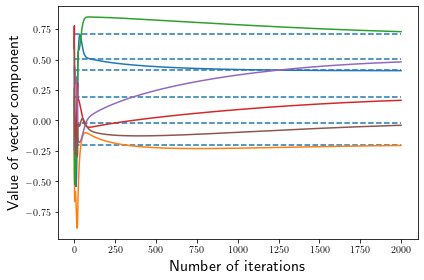

[[ 5.84058423e-01 -2.86296347e-01  1.88188920e-01  4.11289687e-01
  -4.57150794e-01  4.04164615e-01]
 [ 9.99625528e-02  9.88666633e-02  9.38229396e-01 -1.99698133e-01
   2.42822919e-01 -3.34089363e-02]
 [-4.60087941e-01  3.54648396e-01  2.22933416e-01  7.08775848e-01
  -2.61673284e-01 -2.04958981e-01]
 [-3.99403998e-01 -8.64842835e-01  1.21160354e-01  1.89035051e-01
   1.95126235e-01 -6.35215554e-02]
 [ 3.47280403e-01  1.03991421e-01 -1.40848063e-01  5.02561675e-01
   7.72123843e-01 -6.80518225e-04]
 [-3.96327013e-01  1.54003102e-01  9.65478225e-03 -1.71976269e-02
   1.71253605e-01  8.88533158e-01]]
[-2.63982827 -1.7513359   0.58637783 -0.8552386  -0.099044   -0.37108193]


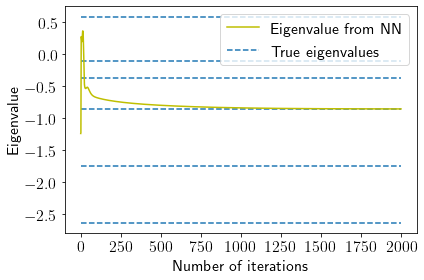

In [221]:
seed = 103
np.random.seed(seed)
tf.random.set_seed(seed)
Q = np.random.randn(6,6)
Q = np.array(Q)
print(Q)
QT = Q.T
A = (QT+Q)/2

true_eigvals, true_eigvecs = np.linalg.eig(A)

t = np.array([0, 1, 2, 3, 4, 5, 10, 20, 100])
x=np.random.randn(6)
layers = [100, 100]
nn = NNEigenSolver(hidden_layers=layers, A=A, learning_rate=0.01)
t = tf.convert_to_tensor(t, dtype=tf.float32)
n_iters = 2000
cost, iterations, eigvals, eigvecs = nn.train(x, t, n_iters)
fsize = 16
eigvec_coordinates = true_eigvecs.T[3, :]
print(eigvec_coordinates)
print(eigvals[-1])
plt.hlines(y = eigvec_coordinates, xmin = 0, xmax = n_iters, linestyles="dashed")
plt.plot(iterations, eigvecs[:,0], label=r'$v_1$')
plt.plot(iterations, eigvecs[:,1], label=r'$v_2$')
plt.plot(iterations, eigvecs[:,2], label=r'$v_3$')
plt.plot(iterations, eigvecs[:,3], label=r'$v_4$')
plt.plot(iterations, eigvecs[:,4], label=r'$v_5$')
plt.plot(iterations, eigvecs[:,5], label=r'$v_6$')
#plt.legend(fontsize=fsize)
plt.xlabel("Number of iterations", fontsize=fsize)
plt.ylabel("Value of vector component", fontsize=fsize)
plt.tight_layout()
plt.savefig("PosAEigenvector.pdf", format="pdf")
plt.show()
print(true_eigvecs)
print(true_eigvals)

plt.plot(iterations, eigvals, label= "Eigenvalue from NN", color="y")
plt.hlines(y = true_eigvals, xmin = 0, xmax = n_iters, linestyles="dashed", label="True eigenvalues")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("Number of iterations", fontsize=fsize)
plt.ylabel("Eigenvalue", fontsize=fsize)
plt.legend(fontsize=fsize)
plt.tight_layout()
plt.savefig("PosAEigenvalue.pdf", format="pdf")
plt.show()

[[-1.24927835 -0.26033141  0.3837933  -0.38546147 -1.08513673  2.32721902]
 [ 0.43079295  0.43231577 -0.98001135 -0.63196519  0.57744207 -0.12475772]
 [ 0.97894786  1.59492154 -1.20194452 -1.37636885  1.05434551 -0.03885348]
 [ 0.68028567  1.3291749   1.28344952 -1.75825367  0.6143059   1.51635808]
 [-0.19597741 -0.81720628 -0.94612771  0.22063891 -0.60073351 -0.15256605]
 [-1.18744311  0.29913821 -0.94776417 -1.84338194  0.81058919 -0.75225658]]
A fifth of iterations done.
Two fifths of iterations done.
Three fifths of iterations done.
Four fifths of iterations done.
Initial cost:  3.2364861965179443
Final cost:  2.0906540387777284e-12
[ 0.28624567 -0.09887811 -0.35460454  0.86488032 -0.10402101 -0.1539605 ]
1.7513360977172852


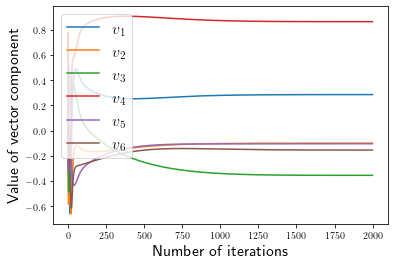

[[ 5.84058423e-01  9.99625528e-02 -4.60087941e-01 -3.99403998e-01
   3.47280403e-01 -3.96327013e-01]
 [-2.86296347e-01  9.88666633e-02  3.54648396e-01 -8.64842835e-01
   1.03991421e-01  1.54003102e-01]
 [ 1.88188920e-01  9.38229396e-01  2.22933416e-01  1.21160354e-01
  -1.40848063e-01  9.65478225e-03]
 [ 4.11289687e-01 -1.99698133e-01  7.08775848e-01  1.89035051e-01
   5.02561675e-01 -1.71976269e-02]
 [-4.57150794e-01  2.42822919e-01 -2.61673284e-01  1.95126235e-01
   7.72123843e-01  1.71253605e-01]
 [ 4.04164615e-01 -3.34089363e-02 -2.04958981e-01 -6.35215554e-02
  -6.80518225e-04  8.88533158e-01]]
[-2.63982827 -1.7513359   0.58637783 -0.8552386  -0.099044   -0.37108193]


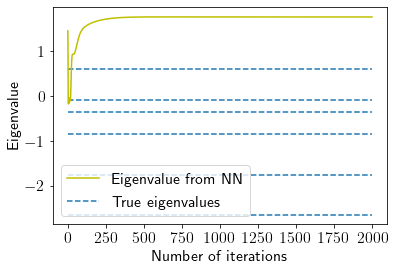

In [206]:
seed = 103
np.random.seed(seed)
tf.random.set_seed(seed)
Q = np.random.randn(6,6)
Q = np.array(Q)
print(Q)
QT = Q.T
A = (QT+Q)/2

true_eigvals, true_eigvecs = np.linalg.eig(A)

t = np.array([0, 1, 2, 3, 4, 5, 10, 20, 100])
x=np.random.randn(6)
layers = [100, 100]
nn = NNEigenSolver(hidden_layers=layers, A=-A, learning_rate=0.01)
t = tf.convert_to_tensor(t, dtype=tf.float32)
n_iters = 2000
cost, iterations, eigvals, eigvecs = nn.train(x, t, n_iters)
fsize = 16
print(eigvecs[-1, :])
print(eigvals[-1])
plt.plot(iterations, eigvecs[:,0], label=r'$v_1$')
plt.plot(iterations, eigvecs[:,1], label=r'$v_2$')
plt.plot(iterations, eigvecs[:,2], label=r'$v_3$')
plt.plot(iterations, eigvecs[:,3], label=r'$v_4$')
plt.plot(iterations, eigvecs[:,4], label=r'$v_5$')
plt.plot(iterations, eigvecs[:,5], label=r'$v_6$')
plt.legend(fontsize=fsize)
plt.xlabel("Number of iterations", fontsize=fsize)
plt.ylabel("Value of vector component", fontsize=fsize)
plt.savefig("NegAEigenvector.pdf", format="pdf")
plt.show()
print(true_eigvecs.T)
print(true_eigvals)

plt.plot(iterations, eigvals, label= "Eigenvalue from NN", color="y")
plt.hlines(y = true_eigvals, xmin = 0, xmax = n_iters, linestyles="dashed", label="True eigenvalues")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("Number of iterations", fontsize=fsize)
plt.ylabel("Eigenvalue", fontsize=fsize)
plt.legend(fontsize=fsize)
plt.savefig("NegAEigenvalue.pdf", format="pdf")
plt.show()

In [211]:

N = 101
h = 1/(N-1)
print(h)
# 

print(np.linspace(0, 1, N))

0.01
[0.0e+00 1.0e-05 2.0e-05 3.0e-05 4.0e-05 5.0e-05 6.0e-05 7.0e-05 8.0e-05
 9.0e-05 1.0e-04 1.1e-04 1.2e-04 1.3e-04 1.4e-04 1.5e-04 1.6e-04 1.7e-04
 1.8e-04 1.9e-04 2.0e-04 2.1e-04 2.2e-04 2.3e-04 2.4e-04 2.5e-04 2.6e-04
 2.7e-04 2.8e-04 2.9e-04 3.0e-04 3.1e-04 3.2e-04 3.3e-04 3.4e-04 3.5e-04
 3.6e-04 3.7e-04 3.8e-04 3.9e-04 4.0e-04 4.1e-04 4.2e-04 4.3e-04 4.4e-04
 4.5e-04 4.6e-04 4.7e-04 4.8e-04 4.9e-04 5.0e-04 5.1e-04 5.2e-04 5.3e-04
 5.4e-04 5.5e-04 5.6e-04 5.7e-04 5.8e-04 5.9e-04 6.0e-04 6.1e-04 6.2e-04
 6.3e-04 6.4e-04 6.5e-04 6.6e-04 6.7e-04 6.8e-04 6.9e-04 7.0e-04 7.1e-04
 7.2e-04 7.3e-04 7.4e-04 7.5e-04 7.6e-04 7.7e-04 7.8e-04 7.9e-04 8.0e-04
 8.1e-04 8.2e-04 8.3e-04 8.4e-04 8.5e-04 8.6e-04 8.7e-04 8.8e-04 8.9e-04
 9.0e-04 9.1e-04 9.2e-04 9.3e-04 9.4e-04 9.5e-04 9.6e-04 9.7e-04 9.8e-04
 9.9e-04 1.0e-03]
